In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import documents as docs
import textcomparisons as tc
import random
import time
import json

start = time.time()

def readArticles(path):
    """ Reads df of articles from the given path, and adds a column
    to store the Document-processed article """
    article_df = pd.read_csv(path)
    article_df["doc"] = None
    return article_df

def dict_by_ids(df, ids):
    """ Given a dataframe of articles and a list of article ids, 
    returns a dictionary with ids as keys and Documents as items, 
    computing and storing the Documents back in the df as needed
    """
    doc_dict = {}
    for doc_id in ids:
        row = df["id"] == doc_id
        doc = df.loc[row, "doc"].iloc[0]
        if doc is None:
            doc = docs.Document(df.loc[row, "text"].iloc[0], clean = False)
            df.loc[row, "doc"] = doc
        doc_dict[doc_id] = doc
    return doc_dict

data_folder = "data"
article_df = pd.read_pickle(os.path.join(data_folder, "article_df_20190601"))

# events = [event for event in np.unique(article_df["event"]) if not np.isnan(event)]
event_path = os.path.join(data_folder, "eventDict2019-06-01.json")
with open(event_path, encoding = "utf8") as json_file:
    events = json.load(json_file)
print(events.keys())
article_df.head(3)

print("Setup time: %d seconds" % np.round(time.time() - start))

dict_keys(['singletons', 'incompleteFingerprints', 'algoGroups', 'events', 'wordDict', 'entityDict'])
Setup time: 2 seconds


In [2]:
N = len(article_df)
N_top50 = np.sum(1 - np.isnan(article_df["event"]))
print("Number of singletons: %d" % len(events['singletons']))
print("Number of articles clustered into top 50 events: %d/%d (.%d)" % (N_top50, N, round(N_top50/N, 2) * 100))

ac = tc.ArticleComparisons()

Number of singletons: 64173
Number of articles clustered into top 50 events: 33124/100756 (.33)


Mean, 5/25/50/75/95 percentiles: 2865.536 [ 169.   820.5 1886.  4004.5 8019.6]


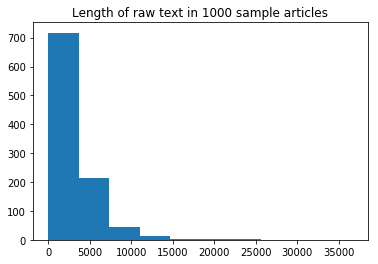

In [7]:
n = 1000
sample = random.sample(list(article_df["id"]), n)
article_dict = dict_by_ids(article_df, sample)
start = time.time()

text_len = [len(article_dict[id].text) for id in article_dict.keys()]
plt.hist(text_len)
plt.title("Length of raw text in %d sample articles" % n)
print("Mean, 5/25/50/75/95 percentiles:", np.mean(text_len), np.percentile(text_len, [5, 25, 50, 75, 95]))

In [8]:
article_dict_good = dict_by_ids(article_df, [i for i in sample if article_df.loc[i, "paywall"] == 0])
article_dict_bad = dict_by_ids(article_df, [i for i in sample if article_df.loc[i, "paywall"] > 0])
print("Sample 'bad' articles: ")
for s in [str(article_dict[i]) for i in random.sample(list(article_dict_bad), 10)]:
    print(s, "\n")
len(article_dict_bad), len(article_dict_good)

Sample 'bad' articles: 
Please enter a valid e-mail address 
 Password must be 6-20 characters 
 registration failed,Please try another Email 

Please enter a valid e-mail address 
 Password must be 6-20 characters 
 registration failed,Please try another Email 

Press J to jump to the feed. Press question mark to learn the rest of the keyboard shortcuts 
 u/kimyonagatari 
  Are you over eighteen and willing to see adult content? 

Report Station 
 Thank you for reporting this station. We will review the data in question. 
 You are about to report this weather station for bad data. Please select the information that is incorrect. 
 Temperature 

@WDBJ7 7 minutes 
 joshua hardy was a neighbor who would mow the lawn next door as a favor one of his grieving neighbors returned 
 Joshua Hardy was a neighbor who would mow the lawn next door as a favor. One of his grieving neighbors returned that favor Saturday as a posthumous tribute after Hardy became one of the 12 people killed in a mass s

(197, 803)

In [9]:
score_mat = ac.jac_score_mat(article_dict_bad)
axislabels = list(article_dict_bad.keys())
clusters = ac.get_article_clusters(article_dict_bad)
ac.prop_unique_clusters()
# 76/400 "bad" articles, .5s, 67.1% unique
# 189/1000 bad articles, 2.5s, 49.2% unique
# 186/1000 bad articles, 7.3s, 52.2% unique
# 184/1000 bad articles, 12s, 49.5% unique
# 183/1000 bad articles, 9.5s, 49.5% 
# 181/1000 bad articles, 6s, 51.4% unique
# 197/1000 bad articles, 8.6s, 53.8% unique 

0 / 197 done, 0.0 seconds elapsed
20 / 197 done, 1.95 seconds elapsed
79 / 197 done, 5.95 seconds elapsed
138 / 197 done, 8.17 seconds elapsed
158 / 197 done, 8.62 seconds elapsed


0.5380710659898477

In [10]:
score_mat = ac.jac_score_mat(article_dict_good)
axislabels = list(article_dict_good.keys())
clusters = ac.get_article_clusters()
ac.prop_unique_clusters()
# 324/400 "good" articles, 8s, 79.0% unique
# 817/1000 good articles, 2.25h, 69% unique
# 819/1000 good articles, 1.25h, 68.5% unique 
# 803/1000 good articles, 1.5h, 67.2% unique 

0 / 803 done, 0.0 seconds elapsed
161 / 803 done, 2120.95 seconds elapsed
241 / 803 done, 3018.49 seconds elapsed
482 / 803 done, 5126.24 seconds elapsed
723 / 803 done, 6045.75 seconds elapsed


0.6724782067247821

In [7]:
n = 1000
singleton_sample = random.sample(list(article_df.loc[np.isnan(article_df["event"]), "id"]), n)
singleton_dict_good = dict_by_ids(article_df, [i for i in singleton_sample if article_df.loc[i, "paywall"] == 0])
singleton_dict_bad = dict_by_ids(article_df, [i for i in singleton_sample if article_df.loc[i, "paywall"] > 0])

In [8]:
score_mat = ac.jac_score_mat(singleton_dict_bad)
print(ac.prop_unique_clusters())

print("%s seconds taken" % np.round(time.time() - start, 2), "for %d bad singleton articles" % len(singleton_dict_bad))
# 261/1000 bad singleton articles, 1.5m, 45.6% unique
# 228/1000 bad singleton articles, 47s, 53.9% unique

0 / 228 done, 0.0 seconds elapsed
23 / 228 done, 2.35 seconds elapsed
46 / 228 done, 4.05 seconds elapsed
137 / 228 done, 10.07 seconds elapsed
160 / 228 done, 11.2 seconds elapsed
0.5394736842105263
46.96 seconds taken for 228 bad singleton articles


In [9]:
score_mat = ac.jac_score_mat(singleton_dict_good)
print(ac.prop_unique_clusters())

print("%s seconds taken" % np.round(time.time() - start, 2), "for %d good singleton articles" % len(singleton_dict_good))
# 772/1000 good singleton articles, ~1.5h, 72.9% unique 

0 / 772 done, 0.0 seconds elapsed
232 / 772 done, 2382.83 seconds elapsed
309 / 772 done, 3113.47 seconds elapsed
618 / 772 done, 4759.21 seconds elapsed
695 / 772 done, 4917.71 seconds elapsed
0.5394736842105263
5012.55 seconds taken for 772 good singleton articles


Average % unique articles, weighted by cluster size (thresh = 0.25):  0.19321817017850287
thresh = 0.75:  0.26730646193909147
Average % unique 'good' articles, weighted by cluster size (thresh = 0.25):  0.18050221567562777
thresh = 0.75:  0.24298375186691287


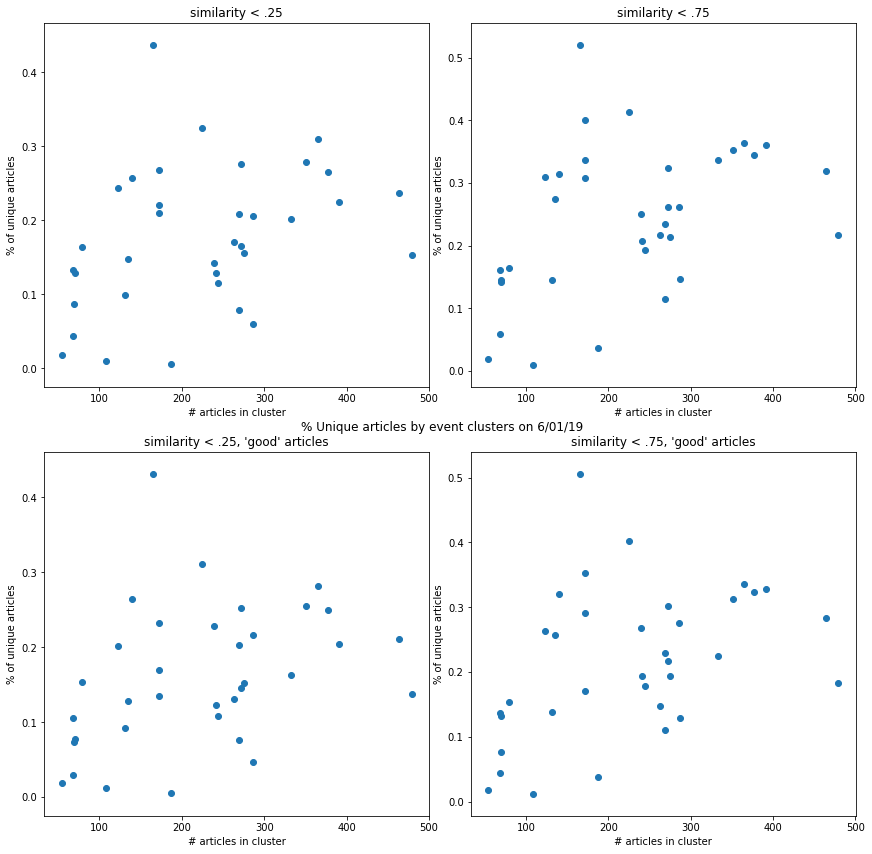

In [4]:
results = pd.read_csv(os.path.join("results", "results_20190601_clusters_temp.csv"))
results = results[[not i for i in np.isnan(results["unique25"])]]
results.loc[results["n"] > 500, "n"] = 500

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 6))
fig.tight_layout()
fig.suptitle("% Unique articles by event clusters on 6/01/19")
fig.subplots_adjust(top = 1.9)

ax1 = axes[0][0]
ax1.scatter(results.loc[:, "n"], results.loc[:, "unique25"])
ax1.set_title("similarity < .25")
ax1.set_xlabel("# articles in cluster")
ax1.set_ylabel("% of unique articles")

ax2 = axes[0][1]
ax2.scatter(results.loc[:, "n"], results.loc[:, "unique75"])
ax2.set_title("similarity < .75")
ax2.set_xlabel("# articles in cluster")
ax2.set_ylabel("% of unique articles")

ax3 = axes[1][0]
ax3.scatter(results.loc[:, "n"], results.loc[:, "unique25_good"])
ax3.set_title("similarity < .25, 'good' articles")
ax3.set_xlabel("# articles in cluster")
ax3.set_ylabel("% of unique articles")

ax4 = axes[1][1]
ax4.scatter(results.loc[:, "n"], results.loc[:, "unique75_good"])
ax4.set_title("similarity < .75, 'good' articles")
ax4.set_xlabel("# articles in cluster")
ax4.set_ylabel("% of unique articles")

print("Average % unique articles, weighted by cluster size (thresh = 0.25): ", np.sum(results.loc[:, "n"] * results.loc[:, "unique25"])/np.sum(results.loc[:, "n"]))
print("thresh = 0.75: ", np.sum(results.loc[:, "n"] * results.loc[:, "unique75"])/np.sum(results.loc[:, "n"]))
print("Average % unique 'good' articles, weighted by cluster size (thresh = 0.25): ", np.sum(results.loc[:, "n_good"] * results.loc[:, "unique25_good"])/np.sum(results.loc[:, "n_good"]))
print("thresh = 0.75: ", np.sum(results.loc[:, "n_good"] * results.loc[:, "unique75_good"])/np.sum(results.loc[:, "n_good"]))

In [5]:
results

,event,n,unique25,unique75,n_good,unique25_good,unique75_good
5,9,479,0.152401,0.217119,372.0,0.137097,0.182796
8,13,269,0.078067,0.115242,263.0,0.076046,0.110266
9,14,464,0.237069,0.318966,426.0,0.211268,0.284038
10,15,187,0.005348,0.037433,0.0,0.005348,0.037433
13,18,272,0.165441,0.261029,254.0,0.145669,0.216535
15,21,377,0.265252,0.344828,356.0,0.250000,0.323034
16,23,286,0.206294,0.262238,218.0,0.215596,0.275229
17,24,391,0.225064,0.360614,362.0,0.204420,0.328729
19,29,269,0.208178,0.234201,231.0,0.203463,0.229437
21,31,272,0.275735,0.323529,262.0,0.251908,0.301527
